In [126]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from scipy.spatial.distance import euclidean

# Propuesta de Nueva Constitución

In [107]:
df_capitulos = pd.read_csv('../data/processed/constitucion_propuesta_capitulos_zero-shot.csv')
groundtruth = pd.read_csv('../data/raw/propuesta_articulos_topicos.csv').sort_values(['n_articulo']).reset_index(drop=True)
constitucion = pd.read_csv('../data/raw/constitucion_propuesta.csv')

Tenemos los artículos de la constitución propuesta:

In [3]:
constitucion.head()

,capitulo,titulo_capitulo,articulo,texto
0,Capítulo I,Principios y Disposiciones Generales,Artículo 1,1. Chile es un Estado social y democrático de ...
1,Capítulo I,Principios y Disposiciones Generales,Artículo 1,2. Se constituye como una república solidaria....
2,Capítulo I,Principios y Disposiciones Generales,Artículo 1,3. La protección y garantía de los derechos hu...
3,Capítulo I,Principios y Disposiciones Generales,Artículo 2,"1. La soberanía reside en el pueblo de Chile, ..."
4,Capítulo I,Principios y Disposiciones Generales,Artículo 2,2. Ningún individuo ni sector del pueblo puede...


Para cada artículo tenemos el tópico asignado por el sitio de Tabla Periódica de la Constitución, esa etiqueta será el groundtruth:

In [4]:
groundtruth.head()

,n_articulo,topico
0,1,Principios y disposiciones generales
1,2,Principios y disposiciones generales
2,3,Principios y disposiciones generales
3,4,Principios y disposiciones generales
4,5,Principios y disposiciones generales


Además tenemos el score entregado por zero-shot clasiffication usando Transformers para cada topico posible:

In [40]:
df_capitulos_pivoted = df_capitulos.pivot(index=['articulo'], columns='topico', values='score')
df_capitulos_pivoted.head()

topico,Acciones constitucionales,Agencia Nacional de Protección de Datos,Autonomía fiscal,Autonomías territoriales indígenas,Banco Central,Bienes comunes naturales,Buen gobierno y función pública,Cambio de Constitución,Comuna autónoma,Consejo de la Justicia,...,Provincia,Reforma Constitucional,Región autónoma,Ruralidad,Sistemas de justicia,Sobre los derechos,Sufragio y sistema electoral,Territorios especiales,Tipos de democracia,Órganos autónomos constitucionales
articulo,,,,,,,,,,,,,,,,,,,,,
Artículo 165,0.095727,0.000887,0.000357,0.000798,0.000907,0.000404,0.326838,0.001219,0.002947,0.001363,...,0.001371,0.001217,0.002357,0.000952,0.000725,0.005058,0.000218,0.008645,0.001704,0.050927
Artículo 166,0.066472,0.001064,0.001340,0.000917,0.001430,0.000955,0.420954,0.001391,0.004501,0.002133,...,0.004024,0.001685,0.002144,0.000827,0.001626,0.005347,0.001146,0.001269,0.002141,0.004535
Artículo 167,0.138894,0.002199,0.001086,0.000684,0.001059,0.001027,0.241858,0.002649,0.009153,0.001627,...,0.003523,0.002769,0.002930,0.000568,0.000792,0.177271,0.000431,0.001386,0.001431,0.036793
Artículo 168,0.114705,0.001568,0.004235,0.001586,0.001578,0.001610,0.051966,0.002768,0.028249,0.002262,...,0.003973,0.005661,0.009499,0.001582,0.002310,0.003154,0.000931,0.004641,0.016340,0.180190
Artículo 169,0.029558,0.024637,0.000631,0.000497,0.001203,0.001022,0.038982,0.002938,0.323607,0.005299,...,0.001526,0.002854,0.008318,0.001371,0.002283,0.012497,0.000512,0.004943,0.002969,0.397352


Calculamos si la etiqueta del groundtruth se encuentra en el topn de topicos más probables para cada artículo según zero-shot classification:

/tmp/ipykernel_709/1101447287.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df_maxs = pd.DataFrame(df_capitulos_pivoted.columns[arr], index=df_capitulos_pivoted.index).reset_index()


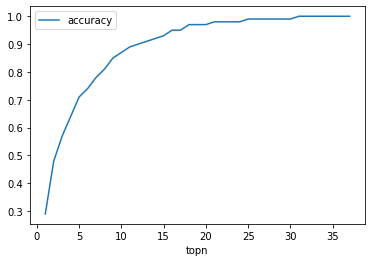

In [44]:
arr = np.argsort(-df_capitulos_pivoted.values, axis=1)
df_maxs = pd.DataFrame(df_capitulos_pivoted.columns[arr], index=df_capitulos_pivoted.index).reset_index()
df_maxs['n_articulo'] = df_maxs['articulo'].str.extract('(\d+)').astype(int)
df_result = pd.merge(df_maxs, groundtruth, on=['n_articulo'], how='left')

accuracy_curve = []
for i in range(0, 37):
    count = [1 if df_result.loc[j,0:i].isin([df_result.loc[j,'topico']]).any() else 0 for j in range(0, len(df_result))]
    accuracy_curve.append([i+1, sum(count)/len(count)])

pd.DataFrame(accuracy_curve, columns = ['topn', 'accuracy']).round(2).set_index(['topn']).plot()
plt.show()

Dado que hay 37 tópicos posibles nos encontramos ante un problema de múltiples clases, usar el top5 de topicos más probables dada la clasificación alcanza cerca de un 71% de accuracy lo cual podría ser aceptable dado que algunos tópicos se parecen mucho entre si. Podemos ver eso con la matriz de confusión usando como predicción la etiqueta top1.

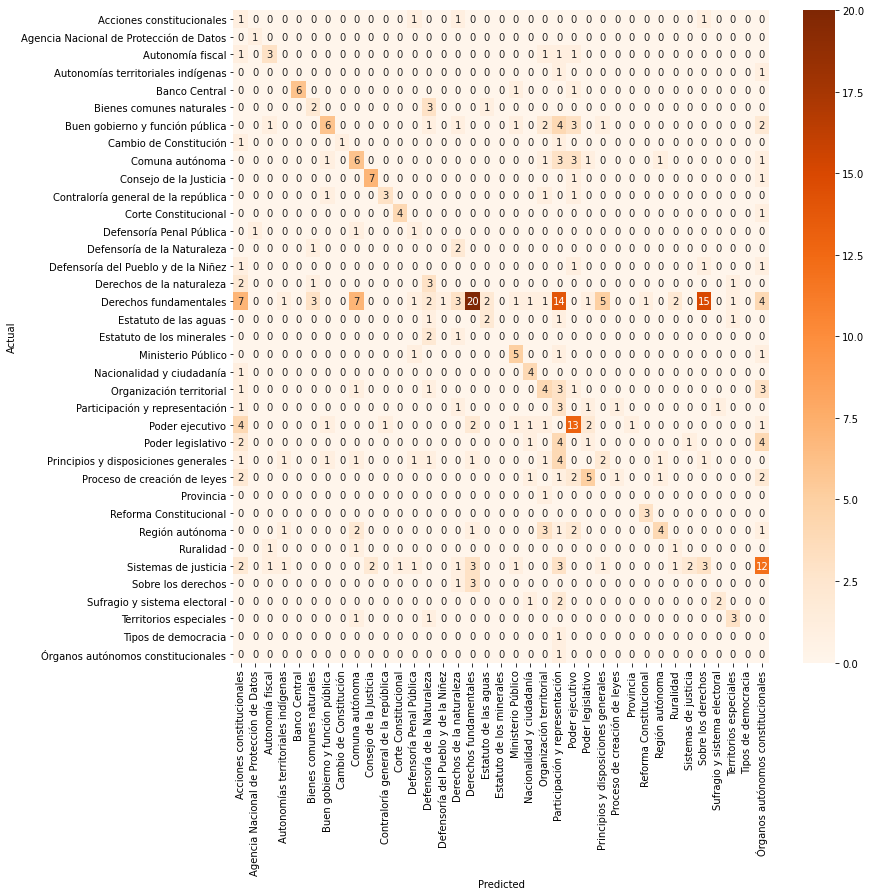

In [63]:
columns_vector = df_capitulos_pivoted.columns.values
cfm = confusion_matrix(df_result['topico'], df_result[0], labels=columns_vector)
df_cm = pd.DataFrame(cfm, index=columns_vector, columns=columns_vector)

fig, ax = plt.subplots(figsize=(12,12)) 
sns.heatmap(df_cm, cmap='Oranges', annot=True, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

# Constitución Vigente

Dado que la estrategia de zero-shot classification parece funcionar bien, apliquemosla a la Constitución Vigente y encontremos los 5 topicos mas probables que predice el modelo.

In [64]:
df_capitulos_vigente = pd.read_csv('../data/processed/constitucion_vigente_capitulos_zero-shot.csv')

In [65]:
df_capitulos_vigente.head()

,articulo,numero,topico,score
0,Artículo 1°,0,Derechos fundamentales,0.203797
1,Artículo 1°,0,Participación y representación,0.199498
2,Artículo 1°,0,Comuna autónoma,0.140183
3,Artículo 1°,0,Sobre los derechos,0.116753
4,Artículo 1°,0,Nacionalidad y ciudadanía,0.109929


In [66]:
df_capitulos_vigente_pivoted = df_capitulos_vigente.pivot(index=['articulo', 'numero'], columns='topico', values='score')
df_capitulos_vigente_pivoted.head()

topico              Acciones constitucionales  \
articulo    numero                              
Artículo 10 0                        0.086834   
            1                        0.034221   
            2                        0.068854   
            3                        0.086448   
            4                        0.060642   

topico              Agencia Nacional de Protección de Datos  Autonomía fiscal  \
articulo    numero                                                              
Artículo 10 0                                      0.015512          0.009653   
            1                                      0.003323          0.002676   
            2                                      0.003797          0.005136   
            3                                      0.005076          0.013482   
            4                                      0.003809          0.004263   

topico              Autonomías territoriales indígenas  Banco Central  \
articulo    numero                                                      
Artículo 10 0                                 0.008412       0.010813   
            1                                 0.001829       0.005219   
            2                                 0.006076       0.009342   
            3                                 0.002421       0.014422   
            4                                 0.003594       0.007709   

topico              Bienes comunes naturales  Buen gobierno y función pública  \
articulo    numero                                                              
Artículo 10 0                       0.013165                         0.009960   
            1                       0.004372                         0.003664   
            2                       0.011149                         0.005293   
            3                       0.011041                         0.008351   
            4                       0.003831                         0.004683   

topico              Cambio de Constitución  Comuna autónoma  \
articulo    numero                                            
Artículo 10 0                     0.005943         0.033432   
            1                     0.003271         0.044111   
            2                     0.003005         0.035116   
            3                     0.008208         0.080196   
            4                     0.007387         0.046674   

topico              Consejo de la Justicia  ...  Provincia  \
articulo    numero                          ...              
Artículo 10 0                     0.043512  ...   0.073151   
            1                     0.006102  ...   0.009453   
            2                     0.010162  ...   0.015635   
            3                     0.014729  ...   0.015959   
            4                     0.009386  ...   0.015865   

topico              Reforma Constitucional  Región autónoma  Ruralidad  \
articulo    numero                                                       
Artículo 10 0                     0.014558         0.023343   0.010433   
            1                     0.006351         0.013407   0.006864   
            2                     0.005364         0.017731   0.013527   
            3                     0.019757         0.043069   0.010006   
            4                     0.006044         0.026052   0.006824   

topico              Sistemas de justicia  Sobre los derechos  \
articulo    numero                                             
Artículo 10 0                   0.013439            0.012311   
            1                   0.002770            0.022750   
            2                   0.005272            0.016949   
            3                   0.004380            0.009450   
            4                   0.003640            0.037253   

topico              Sufragio y sistema electoral  Territorios especiales  \
articulo    numero                                                         
Artículo 10

In [77]:
arr = np.argsort(-df_capitulos_vigente_pivoted.values, axis=1)
df_maxs = pd.DataFrame(df_capitulos_vigente_pivoted.columns[arr], index=df_capitulos_vigente_pivoted.index).reset_index()
df_topicos_predicted = df_maxs.loc[:,['articulo', 'numero', 0, 1, 2, 3, 4]]
df_topicos_predicted.columns = ['articulo', 'numero', 'topico_1', 'topico_2', 'topico_3', 'topico_4', 'topico_5']
df_topicos_predicted.head()

/tmp/ipykernel_709/722762132.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df_maxs = pd.DataFrame(df_capitulos_vigente_pivoted.columns[arr], index=df_capitulos_vigente_pivoted.index).reset_index()


,articulo,numero,topico_1,topico_2,topico_3,topico_4,topico_5
0,Artículo 10,0,Órganos autónomos constitucionales,Acciones constitucionales,Nacionalidad y ciudadanía,Provincia,Principios y disposiciones generales
1,Artículo 10,1,Nacionalidad y ciudadanía,Poder ejecutivo,Principios y disposiciones generales,Comuna autónoma,Participación y representación
2,Artículo 10,2,Nacionalidad y ciudadanía,Acciones constitucionales,Principios y disposiciones generales,Órganos autónomos constitucionales,Comuna autónoma
3,Artículo 10,3,Nacionalidad y ciudadanía,Acciones constitucionales,Comuna autónoma,Órganos autónomos constitucionales,Principios y disposiciones generales
4,Artículo 10,4,Nacionalidad y ciudadanía,Acciones constitucionales,Comuna autónoma,Poder legislativo,Sobre los derechos


In [76]:
constitucion_vigente = pd.read_csv('../data/raw/constitucion_vigente_corregida.csv')
constitucion_vigente_topicos = pd.merge(constitucion_vigente, df_topicos_predicted, on=['articulo', 'numero'], how='left')
constitucion_vigente_topicos.to_csv('../data/processed/constitucion_vigente_con_topicos.csv', index=False)
constitucion_vigente_topicos.head()

,capitulo,titulo_capitulo,articulo,numero,texto,topico_1,topico_2,topico_3,topico_4,topico_5
0,Capítulo I,BASES DE LA INSTITUCIONALIDAD,Artículo 1°,0,Las personas nacen libres e iguales en dignida...,Derechos fundamentales,Participación y representación,Comuna autónoma,Sobre los derechos,Nacionalidad y ciudadanía
1,Capítulo I,BASES DE LA INSTITUCIONALIDAD,Artículo 2º,0,"Son emblemas nacionales la bandera nacional, e...",Órganos autónomos constitucionales,Acciones constitucionales,Comuna autónoma,Nacionalidad y ciudadanía,Poder ejecutivo
2,Capítulo I,BASES DE LA INSTITUCIONALIDAD,Artículo 3º,0,El Estado de Chile es unitario. La administrac...,Órganos autónomos constitucionales,Poder ejecutivo,Acciones constitucionales,Organización territorial,Principios y disposiciones generales
3,Capítulo I,BASES DE LA INSTITUCIONALIDAD,Artículo 4°,0,Chile es una república democrática.,Comuna autónoma,Sobre los derechos,Acciones constitucionales,Participación y representación,Región autónoma
4,Capítulo I,BASES DE LA INSTITUCIONALIDAD,Artículo 5º,0,La soberanía reside esencialmente en la Nación...,Derechos de la naturaleza,Derechos fundamentales,Sobre los derechos,Defensoría de la Naturaleza,Órganos autónomos constitucionales


# Conectando la Constitución Propuesta con la Constitución Vigente

Ya que tenemos una representación en tópicos que parece funcionar en ambos textos, podemos usar los scores como un "embedding" de cada artículo y encontrar los artículos/número de la constitución vigente que más se parecen a cada artículo de la constitución propuesta mediante alguna medida de distancia.

In [81]:
articulos_propuesta = df_capitulos_pivoted.reset_index()
articulos_propuesta['n_articulo'] = articulos_propuesta['articulo'].str.extract('(\d+)').astype(int)
articulos_propuesta.head()

topico,articulo,Acciones constitucionales,Agencia Nacional de Protección de Datos,Autonomía fiscal,Autonomías territoriales indígenas,Banco Central,Bienes comunes naturales,Buen gobierno y función pública,Cambio de Constitución,Comuna autónoma,...,Reforma Constitucional,Región autónoma,Ruralidad,Sistemas de justicia,Sobre los derechos,Sufragio y sistema electoral,Territorios especiales,Tipos de democracia,Órganos autónomos constitucionales,n_articulo
0,Artículo 165,0.095727,0.000887,0.000357,0.000798,0.000907,0.000404,0.326838,0.001219,0.002947,...,0.001217,0.002357,0.000952,0.000725,0.005058,0.000218,0.008645,0.001704,0.050927,165
1,Artículo 166,0.066472,0.001064,0.001340,0.000917,0.001430,0.000955,0.420954,0.001391,0.004501,...,0.001685,0.002144,0.000827,0.001626,0.005347,0.001146,0.001269,0.002141,0.004535,166
2,Artículo 167,0.138894,0.002199,0.001086,0.000684,0.001059,0.001027,0.241858,0.002649,0.009153,...,0.002769,0.002930,0.000568,0.000792,0.177271,0.000431,0.001386,0.001431,0.036793,167
3,Artículo 168,0.114705,0.001568,0.004235,0.001586,0.001578,0.001610,0.051966,0.002768,0.028249,...,0.005661,0.009499,0.001582,0.002310,0.003154,0.000931,0.004641,0.016340,0.180190,168
4,Artículo 169,0.029558,0.024637,0.000631,0.000497,0.001203,0.001022,0.038982,0.002938,0.323607,...,0.002854,0.008318,0.001371,0.002283,0.012497,0.000512,0.004943,0.002969,0.397352,169


In [130]:
constitucion['texto_group'] = constitucion.groupby(['capitulo','titulo_capitulo', 'articulo'])['texto'].transform(lambda x: ' '.join(x))
constitucion = (constitucion[['capitulo', 'titulo_capitulo', 'articulo', 'texto_group']]
                .drop_duplicates()
                .reset_index(drop=True)
                )
constitucion.columns = ['capitulo', 'titulo_capitulo', 'articulo', 'texto']
constitucion['n_articulo'] = constitucion['articulo'].str.extract('(\d+)').astype(int)
propuesta_embeddings = pd.merge(constitucion[['n_articulo', 'texto']], articulos_propuesta, on=['n_articulo'], how='left')
propuesta_embeddings.loc[:,list(columns_vector)] = propuesta_embeddings.loc[:,list(columns_vector)].apply(lambda x: (x-x.mean())/ x.std(), axis=0)
propuesta_embeddings.head()

,n_articulo,texto,articulo,Acciones constitucionales,Agencia Nacional de Protección de Datos,Autonomía fiscal,Autonomías territoriales indígenas,Banco Central,Bienes comunes naturales,Buen gobierno y función pública,...,Provincia,Reforma Constitucional,Región autónoma,Ruralidad,Sistemas de justicia,Sobre los derechos,Sufragio y sistema electoral,Territorios especiales,Tipos de democracia,Órganos autónomos constitucionales
0,1,1. Chile es un Estado social y democrático de ...,Artículo 1,-0.154544,-0.091599,-0.264876,-0.259658,-0.129358,0.097247,-0.156628,...,-0.156370,-0.225220,-0.580688,-0.282457,-0.333802,0.931462,-0.161568,-0.432651,-0.298777,-0.740203
1,2,"1. La soberanía reside en el pueblo de Chile, ...",Artículo 2,-0.790037,-0.275348,-0.280336,-0.287922,-0.209100,-0.348215,-0.381173,...,-0.595997,-0.327221,-0.584574,-0.304665,-0.380526,0.495994,-0.212224,-0.441801,-0.674879,-0.866643
2,3,"Chile, en su diversidad geográfica, natural, h...",Artículo 3,-0.179778,2.059479,-0.094434,-0.232192,0.369771,-0.278633,-0.114504,...,-0.233615,0.731472,-0.298024,-0.097955,0.426747,-0.539466,0.000441,-0.295558,1.691011,-0.314043
3,4,"Las personas nacen y permanecen libres, interd...",Artículo 4,-0.309742,-0.173746,-0.250905,-0.259819,-0.006420,-0.273471,-0.360835,...,0.260956,-0.159591,0.305437,0.049846,-0.358865,-0.459809,-0.200932,-0.434968,-0.070697,-0.623131
4,5,1. Chile reconoce la coexistencia de diversos ...,Artículo 5,-0.254682,-0.160320,-0.269716,0.269781,-0.165651,-0.333432,-0.133877,...,-0.353786,-0.237122,-0.442979,-0.233296,-0.355103,0.501079,0.137986,-0.370053,-0.335735,-0.332612


In [109]:
articulos_vigente = df_capitulos_vigente_pivoted.reset_index()
articulos_vigente.head()

topico,articulo,numero,Acciones constitucionales,Agencia Nacional de Protección de Datos,Autonomía fiscal,Autonomías territoriales indígenas,Banco Central,Bienes comunes naturales,Buen gobierno y función pública,Cambio de Constitución,...,Provincia,Reforma Constitucional,Región autónoma,Ruralidad,Sistemas de justicia,Sobre los derechos,Sufragio y sistema electoral,Territorios especiales,Tipos de democracia,Órganos autónomos constitucionales
0,Artículo 10,0,0.086834,0.015512,0.009653,0.008412,0.010813,0.013165,0.009960,0.005943,...,0.073151,0.014558,0.023343,0.010433,0.013439,0.012311,0.010878,0.026895,0.019727,0.090734
1,Artículo 10,1,0.034221,0.003323,0.002676,0.001829,0.005219,0.004372,0.003664,0.003271,...,0.009453,0.006351,0.013407,0.006864,0.002770,0.022750,0.001355,0.016620,0.015059,0.011508
2,Artículo 10,2,0.068854,0.003797,0.005136,0.006076,0.009342,0.011149,0.005293,0.003005,...,0.015635,0.005364,0.017731,0.013527,0.005272,0.016949,0.000954,0.008303,0.016681,0.035358
3,Artículo 10,3,0.086448,0.005076,0.013482,0.002421,0.014422,0.011041,0.008351,0.008208,...,0.015959,0.019757,0.043069,0.010006,0.004380,0.009450,0.001652,0.009307,0.014987,0.055987
4,Artículo 10,4,0.060642,0.003809,0.004263,0.003594,0.007709,0.003831,0.004683,0.007387,...,0.015865,0.006044,0.026052,0.006824,0.003640,0.037253,0.002891,0.026252,0.014786,0.035070


In [131]:
vigente_embeddings = pd.merge(constitucion_vigente[['articulo', 'numero', 'texto']], articulos_vigente, on=['articulo', 'numero'], how='left')
vigente_embeddings.loc[:,list(columns_vector)] = vigente_embeddings.loc[:,list(columns_vector)].apply(lambda x: (x-x.mean())/ x.std(), axis=0)
vigente_embeddings.head()

,articulo,numero,texto,Acciones constitucionales,Agencia Nacional de Protección de Datos,Autonomía fiscal,Autonomías territoriales indígenas,Banco Central,Bienes comunes naturales,Buen gobierno y función pública,...,Provincia,Reforma Constitucional,Región autónoma,Ruralidad,Sistemas de justicia,Sobre los derechos,Sufragio y sistema electoral,Territorios especiales,Tipos de democracia,Órganos autónomos constitucionales
0,Artículo 1°,0,Las personas nacen libres e iguales en dignida...,-0.306702,-0.619979,-0.316902,-0.570004,-0.227689,-0.245687,-0.277170,...,-0.211674,-0.284960,-0.609893,-0.610058,-0.504138,1.140707,-0.316929,-0.356640,-0.586163,-0.821471
1,Artículo 2º,0,"Son emblemas nacionales la bandera nacional, e...",-0.442695,0.779147,0.518127,-0.199922,-0.137283,0.102890,0.132623,...,-0.310970,-0.034462,0.894031,0.042201,0.299023,-0.324645,-0.247218,-0.140493,0.655792,0.047212
2,Artículo 3º,0,El Estado de Chile es unitario. La administrac...,-0.183139,-0.073168,-0.279711,-0.376956,-0.188034,-0.236135,-0.004720,...,-0.221064,-0.209994,0.611951,0.903067,-0.331482,-0.348829,-0.307087,-0.026039,0.983740,2.075083
3,Artículo 4°,0,Chile es una república democrática.,-0.102185,0.510375,-0.283111,-0.409103,-0.159342,-0.202585,-0.236013,...,0.914341,-0.211101,2.795103,-0.314145,-0.399234,1.281371,-0.212616,-0.346524,-0.037213,-0.807719
4,Artículo 5º,0,La soberanía reside esencialmente en la Nación...,-0.969893,-0.672522,-0.317129,-0.562484,-0.264868,-0.271790,-0.414085,...,-0.515741,-0.298141,-0.329830,-0.625116,-0.523082,2.098331,-0.308921,-0.369739,-0.732547,-0.045741


Ahora que tenemos los artículos de ambas constituciones representados por los vectores de score de cada topico, encontraremos los más parecidos usando norma L2.

In [132]:
def find_similar_articles(article_id, topn=5):
    article_vector = propuesta_embeddings[propuesta_embeddings['n_articulo'] == article_id][list(columns_vector)].values[0]

    similarities = []
    for index, row in vigente_embeddings.iterrows():
        vigente_row_vector = row[list(columns_vector)].values[0]
        distance = euclidean(article_vector, vigente_row_vector)
        similarities.append([row['articulo'], row['numero'], distance, row['texto']])

    df_similarities = pd.DataFrame(similarities, columns=['articulo', 'numero', 'distance', 'texto'])
    df_similarities = df_similarities.sort_values(by=['distance']).head(topn)

    print(f'''
            Para el artículo {article_id} de la consitución propuesta:\n
            {propuesta_embeddings[propuesta_embeddings['n_articulo'] == article_id]['texto'].values[0]}\n

            Los {topn} artículos/número más parecidos de la constitución vigente son:\n
            
            ''')
    
    for index, row in df_similarities.iterrows():
        print(f'{row["articulo"]}-{row["numero"]} / distancia: {row["distance"]}')
        print('\n')
        print(row["texto"])
        print('\n')

In [136]:
find_similar_articles(article_id=110, topn=5)


            Para el artículo 110 de la consitución propuesta:

            1. Ninguna persona puede ser privada de su libertad arbitrariamente ni esta ser restringida, sino en los casos y en la forma determinados por la Constitución y la ley. 2. Ninguna persona puede ser arrestada o detenida sino por orden judicial, salvo que fuera sorprendida en delito flagrante. 3. La persona arrestada o detenida deberá ser puesta a disposición del tribunal competente en un plazo máximo de veinticuatro horas. Se le deben informar de manera inmediata y comprensible sus derechos y los motivos de la privación de su libertad. Tendrá derecho a comunicarse con su abogado o con quien estime pertinente. 4. Ninguna persona puede ser arrestada o detenida, sujeta a prisión preventiva o presa, sino en su domicilio o en los lugares públicos destinados a este objeto. Su ingreso debe constar en un registro público. 5. Se prohíbe la detención por deudas, salvo en caso de incumplimiento de deberes alimentarios.


  